In [17]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score


In [31]:
## data loading ##

## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')
data_gdp = pd.read_csv('data_imf/thailand_gdp_imf.csv', delimiter=';')

data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})
data_gdp = data_gdp.rename(columns={'GDP (Billions of U.S. dollars)': 'gdp'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%d %H:%M:%S')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})
df.set_index('date', inplace=True)

# Calculate the minimum flowrate over the past week / month (base flowrate)
df['min_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).min()
df['min_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).min()

# add lag rainfall features
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)
df['rainfall_lag3'] = df['rainfall'].shift(3)
df['rainfall_lag5weeks'] = df['rainfall'].shift(35)
df['rainfall_week'] = df['rainfall'].rolling(window=7, min_periods=1).mean()
df['rainfall_total_week'] = df['rainfall'].rolling(window=7, min_periods=1).sum()

scaler_rain = StandardScaler()
df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_total_week']] = scaler_rain.fit_transform(df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_total_week']])
scaler_flow = StandardScaler()
df[['flowrate']] = scaler_flow.fit_transform(df[['flowrate']])
scaler_statflow = StandardScaler()
df[['min_flow_week','min_flow_month']] = scaler_statflow.fit_transform(df[['min_flow_week','min_flow_month']])

## encode datetime ##

# extract DateTime components
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# merge with gdp data
df = pd.merge(df, data_gdp, on='year', how='left')

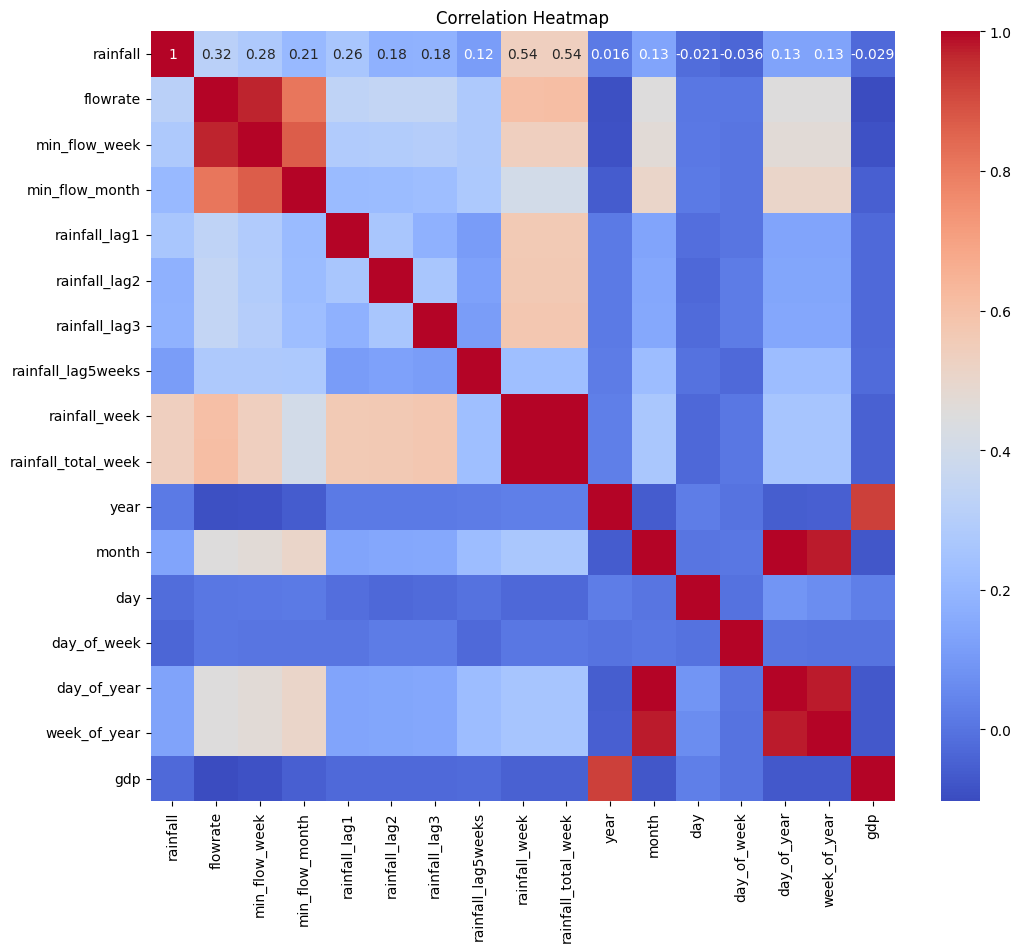

In [32]:
## heatmap ##
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [34]:
# drop non-needed columns
df = df.drop(columns=['year', 'day', 'day_of_week', 'day_of_year', 'rainfall_week'])
# drop rows with missing values
df.dropna(inplace=True)

# separate data by month
df_january = df[df['month'] == 1]
df_february = df[df['month'] == 2]
df_march = df[df['month'] == 3]
df_april = df[df['month'] == 4]
df_may = df[df['month'] == 5]
df_june = df[df['month'] == 6]
df_july = df[df['month'] == 7]
df_august = df[df['month'] == 8]
df_september = df[df['month'] == 9]
df_october = df[df['month'] == 10]
df_november = df[df['month'] == 11]
df_december = df[df['month'] == 12]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4658 entries, 35 to 4692
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rainfall             4658 non-null   float64
 1   flowrate             4658 non-null   float64
 2   min_flow_week        4658 non-null   float64
 3   min_flow_month       4658 non-null   float64
 4   rainfall_lag1        4658 non-null   float64
 5   rainfall_lag2        4658 non-null   float64
 6   rainfall_lag3        4658 non-null   float64
 7   rainfall_lag5weeks   4658 non-null   float64
 8   rainfall_total_week  4658 non-null   float64
 9   month                4658 non-null   int64  
 10  week_of_year         4658 non-null   int32  
 11  gdp                  4658 non-null   float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 454.9 KB


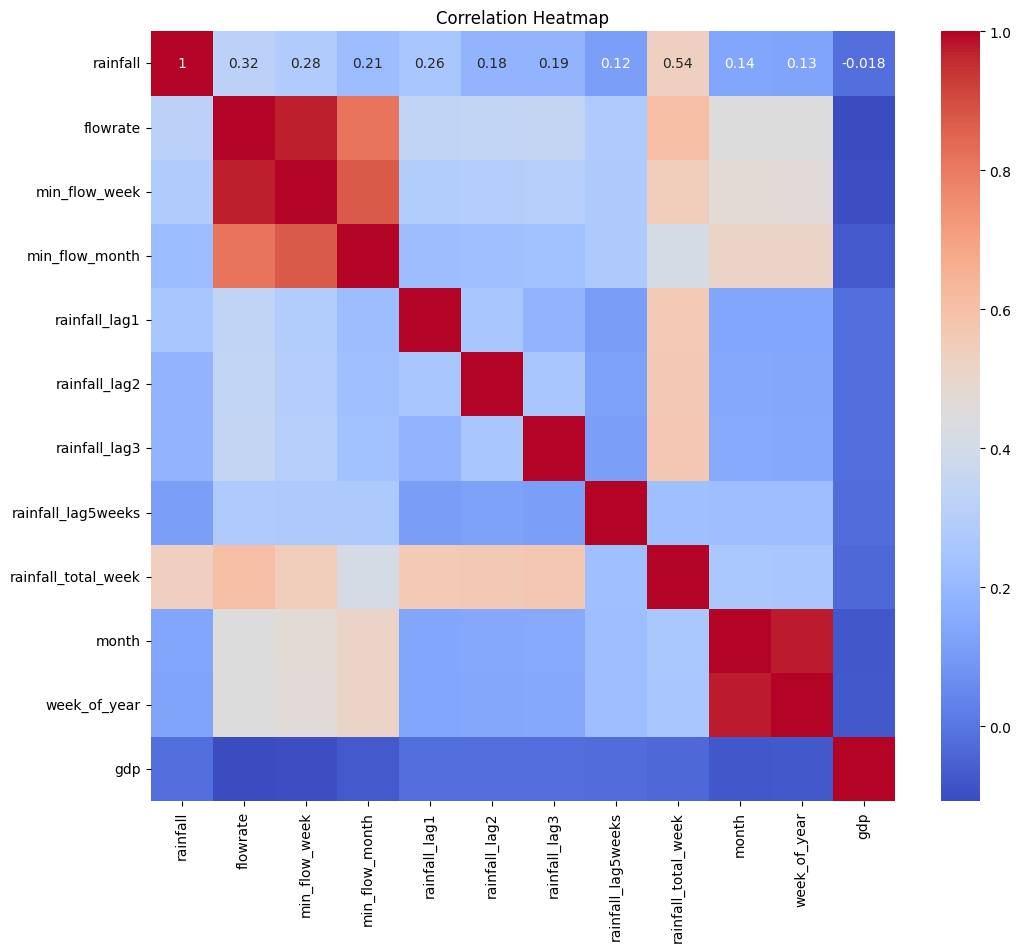

In [35]:
## heatmap ##
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [4]:
## all rainfall lag & weekly and monthly base flowrate ##

X = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_total_week', 'min_flow_week', 'min_flow_month']]
y = df['flowrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

lr_model = LinearRegression()

# Perform 5-fold cross-validation
cv_scores_mse = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(lr_model, X, y, cv=5, scoring='r2')

mean_cv_mse = -cv_scores_mse.mean()
mean_cv_r2 = cv_scores_r2.mean()
print("Linear Regression Model (all data included)")
print("\nCross-Validation Results (5-fold)")
print("Mean Squared Error:", mean_cv_mse)
print("R-squared:", mean_cv_r2)

lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
print("\nMean Squared Error:", lr_mse)
print("R-squared:", lr_r2)

Linear Regression Model (all data included)

Cross-Validation Results (5-fold)
Mean Squared Error: 0.04787178012154839
R-squared: 0.9493429002667341

Mean Squared Error: 0.04840274591131424
R-squared: 0.9543332008450759


In [5]:
## all rainfall lag & no baseline flowrate ##

X2 = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks' , 'rainfall_total_week']]
y2 = df['flowrate']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_train2 = X_train2.sort_index()
y_train2 = y_train2.sort_index()
X_test2 = X_test2.sort_index()
y_test2 = y_test2.sort_index()

lr_model2 = LinearRegression()

# Perform 5-fold cross-validation
cv_scores_mse2 = cross_val_score(lr_model2, X2, y2, cv=5, scoring='neg_mean_squared_error')
cv_scores_r22 = cross_val_score(lr_model2, X2, y2, cv=5, scoring='r2')

mean_cv_mse2 = -cv_scores_mse2.mean()
mean_cv_r22 = cv_scores_r22.mean()
print("\nLinear Regression Model (no baseline flowrate)")
print("\nCross-Validation Results (5-fold)")
print("Mean Squared Error:", mean_cv_mse2)
print("R-squared:", mean_cv_r22)

lr_model2.fit(X_train2, y_train2)
lr_pred2 = lr_model2.predict(X_test2)

lr_mse2 = mean_squared_error(y_test2, lr_pred2)
lr_r22 = r2_score(y_test2, lr_pred2)
print("\nMean Squared Error:", lr_mse2)
print("R-squared:", lr_r22)


Linear Regression Model (no baseline flowrate)

Cross-Validation Results (5-fold)
Mean Squared Error: 0.5853139713608337
R-squared: 0.3694547335915906

Mean Squared Error: 0.5786041160056988
R-squared: 0.45410126102642845


In [6]:
## 5 weeks rainfall lag##

X3 = df[['rainfall', 'week_of_year', 'rainfall_lag5weeks', 'min_flow_week', 'min_flow_month']]
y3 = df['flowrate']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
X_train3 = X_train3.sort_index()
y_train3 = y_train3.sort_index()
X_test3 = X_test3.sort_index()
y_test3 = y_test3.sort_index()

lr_model3 = LinearRegression()

# Perform 5-fold cross-validation
cv_scores_mse3 = cross_val_score(lr_model3, X3, y3, cv=5, scoring='neg_mean_squared_error')
cv_scores_r23 = cross_val_score(lr_model3, X3, y3, cv=5, scoring='r2')

mean_cv_mse3 = -cv_scores_mse3.mean()
mean_cv_r23 = cv_scores_r23.mean()
print("\nLinear Regression Model (5 weeks rainfall lag)")
print("\nCross-Validation Results (5-fold)")
print("Mean Squared Error:", mean_cv_mse3)
print("R-squared:", mean_cv_r23)

lr_model3.fit(X_train3, y_train3)
lr_pred3 = lr_model3.predict(X_test3)

lr_mse3 = mean_squared_error(y_test3, lr_pred3)
lr_r23 = r2_score(y_test3, lr_pred3)
print("\nMean Squared Error:", lr_mse3)
print("R-squared:", lr_r23)


Linear Regression Model (5 weeks rainfall lag)

Cross-Validation Results (5-fold)
Mean Squared Error: 0.05471041723144211
R-squared: 0.9424035027328619

Mean Squared Error: 0.05516853952090564
R-squared: 0.9479498411394305


In [7]:
## All rainfall, no baseline, GDP included ##
X4 = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_total_week', 'gdp']]
y4 = df['flowrate']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42)
X_train4 = X_train4.sort_index()
y_train4 = y_train4.sort_index()
X_test4 = X_test4.sort_index()
y_test4 = y_test4.sort_index()

lr_model4 = LinearRegression()

# Perform 5-fold cross-validation
cv_scores_mse4 = cross_val_score(lr_model4, X4, y4, cv=5, scoring='neg_mean_squared_error')
cv_scores_r24 = cross_val_score(lr_model4, X4, y4, cv=5, scoring='r2')

mean_cv_mse4 = -cv_scores_mse4.mean()
mean_cv_r24 = cv_scores_r24.mean()
print("\nLinear Regression Model (no baseline flowrate, GDP included)")
print("\nCross-Validation Results (5-fold)")
print("Mean Squared Error:", mean_cv_mse4)
print("R-squared:", mean_cv_r24)

lr_model4.fit(X_train4, y_train4)
lr_pred4 = lr_model4.predict(X_test4)

lr_mse4 = mean_squared_error(y_test4, lr_pred4)
lr_r24 = r2_score(y_test4, lr_pred4)
print("\nMean Squared Error:", lr_mse4)
print("R-squared:", lr_r24)


Linear Regression Model (no baseline flowrate, GDP included)

Cross-Validation Results (5-fold)
Mean Squared Error: 0.6213071493414165
R-squared: 0.32768516327214187

Mean Squared Error: 0.5714294494437335
R-squared: 0.4608703822967205


In [8]:
## Polynomial and interaction features (all data) ##

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Train-test split with polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

sorted_train_indices = np.argsort(y_train.index)
sorted_test_indices = np.argsort(y_test.index)

X_train_poly = X_train_poly[sorted_train_indices]
y_train = y_train.iloc[sorted_train_indices].values
X_test_poly = X_test_poly[sorted_test_indices]
y_test = y_test.iloc[sorted_test_indices].values

# Linear Regression with polynomial features
lr_poly_model = LinearRegression()
lr_poly_model.fit(X_train_poly, y_train)
lr_poly_pred = lr_poly_model.predict(X_test_poly)

lr_poly_mse = mean_squared_error(y_test, lr_poly_pred)
lr_poly_r2 = r2_score(y_test, lr_poly_pred)

print("Linear Regression Model with Polynomial Features")
print("Mean Squared Error on Test Set:", lr_poly_mse)
print("R-squared on Test Set:", lr_poly_r2)

# reverse scaling
y_test = scaler_flow.inverse_transform(y_test.reshape(-1, 1))
lr_poly_pred = scaler_flow.inverse_transform(lr_pred.reshape(-1, 1))

# Extract coefficients
coefficients = lr_poly_model.coef_
intercept = lr_poly_model.intercept_

# Get feature names
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Display polynomial equation
equation = f"{intercept}"
for coef, name in zip(coefficients, feature_names):
    equation += f" + ({coef} * {name})"

print("Polynomial Regression Equation:")
print(equation)

Linear Regression Model with Polynomial Features
Mean Squared Error on Test Set: 0.04560915338656452
R-squared on Test Set: 0.9569688866175772
Polynomial Regression Equation:
0.13570413961736705 + (0.047596853107507796 * rainfall) + (-0.00042715216576504197 * week_of_year) + (0.04411591825864201 * rainfall_lag1) + (0.04695153146639655 * rainfall_lag2) + (0.0695609133538607 * rainfall_lag3) + (0.026524191267663505 * rainfall_lag5weeks) + (-0.04940942254370093 * rainfall_total_week) + (1.2185389017444346 * min_flow_week) + (-0.07772859745468497 * min_flow_month) + (-0.007989841180308254 * rainfall^2) + (-0.0012750157563782075 * rainfall week_of_year) + (-0.01497931480160098 * rainfall rainfall_lag1) + (-0.006054933171496774 * rainfall rainfall_lag2) + (-0.014212861839565528 * rainfall rainfall_lag3) + (-0.0067579463166355935 * rainfall rainfall_lag5weeks) + (0.02191068470956266 * rainfall rainfall_total_week) + (-0.00556856447740145 * rainfall min_flow_week) + (0.020845286547640375 * rai

In [9]:
## polynomial features (no baseline flowrate) ##

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly2 = poly2.fit_transform(X2)

# Train-test split with polynomial features
X_train_poly2, X_test_poly2, y_train2, y_test2 = train_test_split(X_poly2, y2, test_size=0.2, random_state=42)

sorted_train_indices2 = np.argsort(y_train2.index)
sorted_test_indices2 = np.argsort(y_test2.index)

X_train_poly2 = X_train_poly2[sorted_train_indices2]
y_train2 = y_train2.iloc[sorted_train_indices2].values
X_test_poly2 = X_test_poly2[sorted_test_indices2]
y_test2 = y_test2.iloc[sorted_test_indices2].values

# Linear Regression with polynomial features
lr_poly_model2 = LinearRegression()
lr_poly_model2.fit(X_train_poly2, y_train2)
lr_poly_pred2 = lr_poly_model2.predict(X_test_poly2)

lr_poly_mse2 = mean_squared_error(y_test2, lr_poly_pred2)
lr_poly_r22 = r2_score(y_test2, lr_poly_pred2)

print("\nLinear Regression Model with Polynomial Features (no baseline flowrate)")
print("Mean Squared Error on Test Set:", lr_poly_mse2)
print("R-squared on Test Set:", lr_poly_r22)

# reverse scaling
y_test2 = scaler_flow.inverse_transform(y_test2.reshape(-1, 1))
lr_poly_pred2 = scaler_flow.inverse_transform(lr_pred2.reshape(-1, 1))

# Extract coefficients
coefficients2 = lr_poly_model2.coef_
intercept2 = lr_poly_model2.intercept_

# Get feature names
feature_names2 = poly2.get_feature_names_out(input_features=X2.columns)

# Display polynomial equation
equation2 = f"{intercept2}"
for coef, name in zip(coefficients2, feature_names2):
    equation2 += f" + ({coef} * {name})"
print("Polynomial Regression Equation:")
print(equation2)


Linear Regression Model with Polynomial Features (no baseline flowrate)
Mean Squared Error on Test Set: 0.4308813410823544
R-squared on Test Set: 0.5934740624247791
Polynomial Regression Equation:
-1.2497730930827742 + (-0.03490690471370338 * rainfall) + (0.07997824604050492 * week_of_year) + (-0.04777610603974247 * rainfall_lag1) + (0.017459985126635647 * rainfall_lag2) + (0.05765786452783517 * rainfall_lag3) + (0.2309183314865342 * rainfall_lag5weeks) + (-0.2932736656391029 * rainfall_total_week) + (-0.026932915483252627 * rainfall^2) + (0.0007943035455272103 * rainfall week_of_year) + (-0.03507476054740733 * rainfall rainfall_lag1) + (-0.03052712544644464 * rainfall rainfall_lag2) + (-0.03364353312169332 * rainfall rainfall_lag3) + (-0.0009573168511930932 * rainfall rainfall_lag5weeks) + (0.07718275565682842 * rainfall rainfall_total_week) + (-0.0008501683517967339 * week_of_year^2) + (0.0030637233764640613 * week_of_year rainfall_lag1) + (0.0005698220075744426 * week_of_year rainf

In [10]:
## polynomial features (5 weeks rainfall lag) ##
poly3 = PolynomialFeatures(degree=2, include_bias=False)
X_poly3 = poly3.fit_transform(X3)

# Train-test split with polynomial features
X_train_poly3, X_test_poly3, y_train3, y_test3 = train_test_split(X_poly3, y3, test_size=0.2, random_state=42)

sorted_train_indices3 = np.argsort(y_train3.index)
sorted_test_indices3 = np.argsort(y_test3.index)

X_train_poly3 = X_train_poly3[sorted_train_indices3]
y_train3 = y_train3.iloc[sorted_train_indices3].values
X_test_poly3 = X_test_poly3[sorted_test_indices3]
y_test3 = y_test3.iloc[sorted_test_indices3].values

# Linear Regression with polynomial features
lr_poly_model3 = LinearRegression()
lr_poly_model3.fit(X_train_poly3, y_train3)
lr_poly_pred3 = lr_poly_model3.predict(X_test_poly3)

lr_poly_mse3 = mean_squared_error(y_test3, lr_poly_pred3)
lr_poly_r23 = r2_score(y_test3, lr_poly_pred3)

print("\nLinear Regression Model with Polynomial Features (5 weeks rainfall lag)")
print("Mean Squared Error on Test Set:", lr_poly_mse3)
print("R-squared on Test Set:", lr_poly_r23)

# reverse scaling
y_test3 = scaler_flow.inverse_transform(y_test3.reshape(-1, 1))
lr_poly_pred3 = scaler_flow.inverse_transform(lr_pred3.reshape(-1, 1))

# Extract coefficients
coefficients3 = lr_poly_model3.coef_
intercept3 = lr_poly_model3.intercept_

# Get feature names
feature_names3 = poly3.get_feature_names_out(input_features=X3.columns)

# Display polynomial equation
equation3 = f"{intercept3}"
for coef, name in zip(coefficients3, feature_names3):
    equation3 += f" + ({coef} * {name})"
print("Polynomial Regression Equation:")
print(equation3)


Linear Regression Model with Polynomial Features (5 weeks rainfall lag)
Mean Squared Error on Test Set: 0.05069253025587428
R-squared on Test Set: 0.9521728456874842
Polynomial Regression Equation:
0.08440000533636992 + (0.0612516863312201 * rainfall) + (0.0033666644829478294 * week_of_year) + (0.03619427168329724 * rainfall_lag5weeks) + (1.0801828906428148 * min_flow_week) + (0.033153208386851166 * min_flow_month) + (-0.009131235100311458 * rainfall^2) + (2.8896264344819308e-05 * rainfall week_of_year) + (-0.005969995508268477 * rainfall rainfall_lag5weeks) + (0.0007749885830838685 * rainfall min_flow_week) + (0.009627607252351992 * rainfall min_flow_month) + (-9.623800995761477e-05 * week_of_year^2) + (-0.0003921072655510844 * week_of_year rainfall_lag5weeks) + (0.003017185262643039 * week_of_year min_flow_week) + (-0.006443284414395011 * week_of_year min_flow_month) + (-0.0021359910508834366 * rainfall_lag5weeks^2) + (0.009138755453846572 * rainfall_lag5weeks min_flow_week) + (-0.0

In [11]:
## polynomial features (all data, no baseline, GDP included) ##
poly4 = PolynomialFeatures(degree=2, include_bias=False)
X_poly4 = poly4.fit_transform(X4)

# Train-test split with polynomial features
X_train_poly4, X_test_poly4, y_train4, y_test4 = train_test_split(X_poly4, y4, test_size=0.2, random_state=42)

sorted_train_indices4 = np.argsort(y_train4.index)
sorted_test_indices4 = np.argsort(y_test4.index)

X_train_poly4 = X_train_poly4[sorted_train_indices4]
y_train4 = y_train4.iloc[sorted_train_indices4].values
X_test_poly4 = X_test_poly4[sorted_test_indices4]
y_test4 = y_test4.iloc[sorted_test_indices4].values

# Linear Regression with polynomial features
lr_poly_model4 = LinearRegression()
lr_poly_model4.fit(X_train_poly4, y_train4)
lr_poly_pred4 = lr_poly_model4.predict(X_test_poly4)

lr_poly_mse4 = mean_squared_error(y_test4, lr_poly_pred4)
lr_poly_r24 = r2_score(y_test4, lr_poly_pred4)

print("\nLinear Regression Model with Polynomial Features (no baseline flowrate, GDP included)")
print("Mean Squared Error on Test Set:", lr_poly_mse4)
print("R-squared on Test Set:", lr_poly_r24)

# reverse scaling
y_test4 = scaler_flow.inverse_transform(y_test4.reshape(-1, 1))
lr_poly_pred4 = scaler_flow.inverse_transform(lr_pred4.reshape(-1, 1))

# Extract coefficients
coefficients4 = lr_poly_model4.coef_
intercept4 = lr_poly_model4.intercept_

# Get feature names
feature_names4 = poly4.get_feature_names_out(input_features=X4.columns)

# Display polynomial equation
equation4 = f"{intercept4}"
for coef, name in zip(coefficients4, feature_names4):
    equation4 += f" + ({coef} * {name})"
print("Polynomial Regression Equation:")
print(equation4)


Linear Regression Model with Polynomial Features (no baseline flowrate, GDP included)
Mean Squared Error on Test Set: 0.41913110862134817
R-squared on Test Set: 0.6045601174763584
Polynomial Regression Equation:
-4.780604298992839 + (-0.047589296040684105 * rainfall) + (0.10896441741309244 * week_of_year) + (0.07341080202838313 * rainfall_lag1) + (-0.011524978500531666 * rainfall_lag2) + (0.04974004685275761 * rainfall_lag3) + (0.2004278400121289 * rainfall_lag5weeks) + (-0.12025423223130936 * rainfall_total_week) + (0.01517703988482057 * gdp) + (-0.027656702881231208 * rainfall^2) + (0.0006845695892750452 * rainfall week_of_year) + (-0.03366379100211339 * rainfall rainfall_lag1) + (-0.03276766527571909 * rainfall rainfall_lag2) + (-0.03333083834679661 * rainfall rainfall_lag3) + (-0.002782412078088626 * rainfall rainfall_lag5weeks) + (0.07984831897617137 * rainfall rainfall_total_week) + (3.866257392926762e-05 * rainfall gdp) + (-0.000878079170459984 * week_of_year^2) + (0.0024381144

In [12]:
## dataframe to store results ##
results = pd.DataFrame(columns=['Linear Reg Model', 'Mean Squared Error', 'R-squared'])
results.loc[0] = ['All Data', lr_mse, lr_r2]
results.loc[1] = ['All Data (Polynomial features)', lr_poly_mse, lr_poly_r2]
results.loc[2] = ['No Baseline Flowrate', lr_mse2, lr_r22]
results.loc[3] = ['No Baseline Flowrate (Polynomial features)', lr_poly_mse2, lr_poly_r22]
results.loc[4] = ['Only 5 weeks Rainfall Lag', lr_mse3, lr_r23]
results.loc[5] = ['Only 5 weeks Rainfall Lag (Polynomial features)', lr_poly_mse3, lr_poly_r23]
results.loc[6] = ['No Baseline (GDP included)', lr_mse4, lr_r24]
results.loc[7] = ['No Baseline (GDP included, Polynomial features)', lr_poly_mse4, lr_poly_r24]
results = results.sort_values(by='Mean Squared Error')
results

,Linear Reg Model,Mean Squared Error,R-squared
1,All Data (Polynomial features),0.045609,0.956969
0,All Data,0.048403,0.954333
5,Only 5 weeks Rainfall Lag (Polynomial features),0.050693,0.952173
4,Only 5 weeks Rainfall Lag,0.055169,0.947950
7,"No Baseline (GDP included, Polynomial features)",0.419131,0.604560
3,No Baseline Flowrate (Polynomial features),0.430881,0.593474
6,No Baseline (GDP included),0.571429,0.460870
2,No Baseline Flowrate,0.578604,0.454101


In [13]:
## all data - monthly ##

def linreg(data, month):
    X = data[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_total_week', 'min_flow_week', 'min_flow_month']]
    y = data['flowrate']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.sort_index()
    y_train = y_train.sort_index()
    X_test = X_test.sort_index()
    y_test = y_test.sort_index()

    lr_model = LinearRegression()

    # Perform 5-fold cross-validation
    cv_scores_mse = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores_r2 = cross_val_score(lr_model, X, y, cv=5, scoring='r2')

    #mean_cv_mse = -cv_scores_mse.mean()
    #mean_cv_r2 = cv_scores_r2.mean()

    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)

    lr_mse = mean_squared_error(y_test, lr_pred)
    lr_r2 = r2_score(y_test, lr_pred)
    return lr_mse, lr_r2

jan_mse, jan_r2 = linreg(df_january, 'January')
feb_mse, feb_r2 = linreg(df_february, 'February')
mar_mse, mar_r2 = linreg(df_march, 'March')
apr_mse, apr_r2 = linreg(df_april, 'April')
may_mse, may_r2 = linreg(df_may, 'May')
jun_mse, jun_r2 = linreg(df_june, 'June')
jul_mse, jul_r2 = linreg(df_july, 'July')
aug_mse, aug_r2 = linreg(df_august, 'August')
sep_mse, sep_r2 = linreg(df_september, 'September')
oct_mse, oct_r2 = linreg(df_october, 'October')
nov_mse, nov_r2 = linreg(df_november, 'November')
dec_mse, dec_r2 = linreg(df_december, 'December')

In [14]:
## all data - monthly - polynomial features ##

def linreg_poly(data, month):
    X = data[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'min_flow_week', 'min_flow_month']]
    y = data['flowrate']

    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Train-test split with polynomial features
    X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

    sorted_train_indices = np.argsort(y_train.index)
    sorted_test_indices = np.argsort(y_test.index)

    X_train_poly = X_train_poly[sorted_train_indices]
    y_train = y_train.iloc[sorted_train_indices].values
    X_test_poly = X_test_poly[sorted_test_indices]
    y_test = y_test.iloc[sorted_test_indices].values

    # Linear Regression with polynomial features
    lr_poly_model = LinearRegression()
    lr_poly_model.fit(X_train_poly, y_train)
    lr_poly_pred = lr_poly_model.predict(X_test_poly)

    lr_poly_mse = mean_squared_error(y_test, lr_poly_pred)
    lr_poly_r2 = r2_score(y_test, lr_poly_pred)
    return lr_poly_mse, lr_poly_r2

jan_mse_poly, jan_r2_poly = linreg_poly(df_january, 'January')
feb_mse_poly, feb_r2_poly = linreg_poly(df_february, 'February')
mar_mse_poly, mar_r2_poly = linreg_poly(df_march, 'March')
apr_mse_poly, apr_r2_poly = linreg_poly(df_april, 'April')
may_mse_poly, may_r2_poly = linreg_poly(df_may, 'May')
jun_mse_poly, jun_r2_poly = linreg_poly(df_june, 'June')
jul_mse_poly, jul_r2_poly = linreg_poly(df_july, 'July')
aug_mse_poly, aug_r2_poly = linreg_poly(df_august, 'August')
sep_mse_poly, sep_r2_poly = linreg_poly(df_september, 'September')
oct_mse_poly, oct_r2_poly = linreg_poly(df_october, 'October')
nov_mse_poly, nov_r2_poly = linreg_poly(df_november, 'November')
dec_mse_poly, dec_r2_poly = linreg_poly(df_december, 'December')

In [15]:
## monthly results ##
results_monthly = pd.DataFrame(columns=['Month', 'Linear Reg Model', 'Mean Squared Error', 'R-squared'])
results_monthly.loc[0] = ['January', 'classic', jan_mse, jan_r2]
results_monthly.loc[1] = ['February', 'classic', feb_mse, feb_r2]
results_monthly.loc[2] = ['March', 'classic', mar_mse, mar_r2]
results_monthly.loc[3] = ['April', 'classic', apr_mse, apr_r2]
results_monthly.loc[4] = ['May', 'classic', may_mse, may_r2]
results_monthly.loc[5] = ['June', 'classic', jun_mse, jun_r2]
results_monthly.loc[6] = ['July', 'classic', jul_mse, jul_r2]
results_monthly.loc[7] = ['August', 'classic', aug_mse, aug_r2]
results_monthly.loc[8] = ['September', 'classic', sep_mse, sep_r2]
results_monthly.loc[9] = ['October', 'classic', oct_mse, oct_r2]
results_monthly.loc[10] = ['November', 'classic', nov_mse, nov_r2]
results_monthly.loc[11] = ['December', 'classic', dec_mse, dec_r2]
results_monthly.loc[12] = ['January', 'polynomial', jan_mse_poly, jan_r2_poly]
results_monthly.loc[13] = ['February', 'polynomial', feb_mse_poly, feb_r2_poly]
results_monthly.loc[14] = ['March', 'polynomial', mar_mse_poly, mar_r2_poly]
results_monthly.loc[15] = ['April', 'polynomial', apr_mse_poly, apr_r2_poly]
results_monthly.loc[16] = ['May', 'polynomial', may_mse_poly, may_r2_poly]
results_monthly.loc[17] = ['June', 'polynomial', jun_mse_poly, jun_r2_poly]
results_monthly.loc[18] = ['July', 'polynomial', jul_mse_poly, jul_r2_poly]
results_monthly.loc[19] = ['August', 'polynomial', aug_mse_poly, aug_r2_poly]
results_monthly.loc[20] = ['September', 'polynomial', sep_mse_poly, sep_r2_poly]
results_monthly.loc[21] = ['October', 'polynomial', oct_mse_poly, oct_r2_poly]
results_monthly.loc[22] = ['November', 'polynomial', nov_mse_poly, nov_r2_poly]
results_monthly.loc[23] = ['December', 'polynomial', dec_mse_poly, dec_r2_poly]
results_monthly = results_monthly.sort_values(by='Mean Squared Error')
results_monthly

,Month,Linear Reg Model,Mean Squared Error,R-squared
3,April,classic,4.147521e-04,9.357536e-01
2,March,classic,4.482516e-04,9.412601e-01
0,January,classic,4.511326e-04,9.288711e-01
1,February,classic,5.205632e-04,8.617138e-01
12,January,polynomial,6.627950e-04,8.954988e-01
11,December,classic,1.141102e-03,9.387410e-01
15,April,polynomial,2.819308e-03,5.632801e-01
10,November,classic,5.536907e-03,9.374206e-01
16,May,polynomial,6.986028e-03,7.796261e-01
4,May,classic,7.433921e-03,7.654973e-01


In [16]:
## Combined model ##

final_pred = lr_poly_pred

# use monthly projections for wet season months (December-April) based on week numbers

